<a href="https://colab.research.google.com/github/JoseTobon/AI_Notebooks/blob/main/U-NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Architecture

José Angel Tobón Salazar A01411655

From https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dataset

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDZO6EJ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDZO6EJ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# Función para redimensionar la imagen y la máscara a un tamaño específico (128, 128)

def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [4]:
# Función para aumentar el conjunto de datos. Si un número aleatorio es mayor a 0.5, la imagen y la máscara se voltean horizontalmente
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [5]:
# Función para normalizar la imagen y la máscara. La imagen se divide por 255 para que sus valores estén en el rango [0, 1]. A la máscara se le resta 1.
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [6]:
# Funciones para cargar y preprocesar las imágenes de entrenamiento y prueba. Primero se redimensionan, luego se aumentan (solo para las de entrenamiento) y finalmente se normalizan.

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [7]:
# Creación del pipeline de entrada. Se mapean las funciones de carga y preprocesamiento a los conjuntos de datos de entrenamiento y prueba.

train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# Definición de los lotes (batches). Se definen los tamaños de los lotes y se crean los lotes para los conjuntos de datos de entrenamiento, validación y prueba.

BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

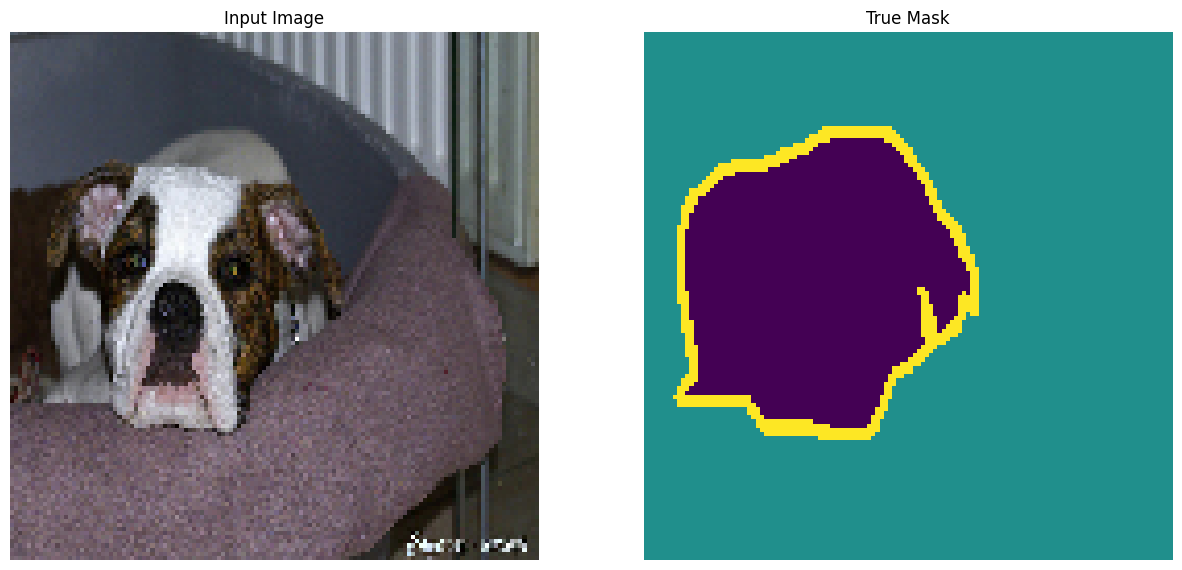

In [9]:
# Función para visualizar una lista de imágenes. Se utiliza para visualizar la imagen de entrada, la máscara verdadera y la máscara predicha.

def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

# Selecciona una imagen y una máscara aleatorias del conjunto de entrenamiento y las visualiza

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Building Architecture

---

Definición de las operaciones fundamentales de un modelo U-Net: una operación de convolución doble, una operación de muestreo descendente y una operación de muestreo ascendente. Estas operaciones se utilizan para construir la arquitectura completa del U-Net, que consta de una parte de contracción (que reduce la resolución espacial de la entrada y aumenta su profundidad) y una parte de expansión (que aumenta la resolución espacial de la entrada y reduce su profundidad), con una capa de cuello de botella entre ambas.

In [10]:
# Función para realizar dos convoluciones seguidas. Se utiliza en varias partes de la U-Net.

'''
Define una función llamada double_conv_block que realiza dos operaciones de convolución 2D seguidas. En cada operación de convolución, se aplica un filtro
(o kernel) a la entrada x. Este filtro tiene un tamaño de 3x3, se aplica con un relleno (‘padding’) de tipo ‘same’ (lo que significa que se añade un relleno a
la entrada para que la salida tenga el mismo tamaño que la entrada), se utiliza una función de activación ReLU (Rectified Linear Unit) para introducir no linealidades
en el modelo, y se inicializa con el inicializador ‘he_normal’ (que es una forma de inicialización de pesos recomendada para redes neuronales profundas). El número de
filtros en cada operación de convolución es n_filters. Después de aplicar las dos convoluciones, la función devuelve la salida.
'''

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [11]:
# Función para realizar una convolución seguida de un MaxPooling. Se utiliza en la parte de contracción de la U-Net.

'''
Definición de función llamada downsample_block que realiza una operación de muestreo descendente (downsampling). Primero, se aplica la función double_conv_block a la
entrada x para realizar dos convoluciones 2D. Luego, se aplica una operación de MaxPooling con un tamaño de pool de 2x2 para reducir la resolución espacial de la entrada
(es decir, para reducir su altura y anchura). Finalmente, se aplica una operación de Dropout con una tasa de 0.3 para prevenir el sobreajuste durante el entrenamiento.
La función devuelve tanto la salida de la operación de convolución (f) como la salida de la operación de Dropout (p).
'''

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [12]:
# Función para realizar una transposición de convolución seguida de una concatenación. Se utiliza en la parte de expansión de la U-Net.

'''
Definición de función llamada upsample_block que realiza una operación de muestreo ascendente (upsampling). Primero, se aplica una operación de transposición de convolución
2D a la entrada x para aumentar su resolución espacial (es decir, para aumentar su altura y anchura). Luego, se concatena la salida de esta operación con las características
de convolución conv_features de la parte de contracción del U-Net. Después, se aplica una operación de Dropout con una tasa de 0.3 para prevenir el sobreajuste durante el
entrenamiento. Finalmente, se aplica la función double_conv_block para realizar dos convoluciones 2D. La función devuelve la salida de estas convoluciones.
'''

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenar
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

### U-Net Model

In [13]:
# Función para construir el modelo completo de la U-Net. Se definen las entradas, se construyen las partes de contracción y expansión y se definen las salidas.

'''
Se define la función build_unet_model que construye el modelo completo de la U-Net. Primero, se definen las entradas del modelo. Luego, se construye la parte de contracción
del U-Net utilizando la función downsample_block definida anteriormente. Después de la contracción, se aplica una operación de convolución doble para crear el cuello de botella
del U-Net. A continuación, se construye la parte de expansión del U-Net utilizando la función upsample_block definida anteriormente. Finalmente, se definen las salidas del modelo
y se crea el modelo U-Net utilizando la API funcional de Keras.
'''

def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [14]:
# Creación del modelo de la U-Net

unet_model = build_unet_model()

## Compile and Train

In [15]:
# Compilación del modelo. Se define el optimizador, la función de pérdida y las métricas.

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [16]:
# Entrenamiento del modelo. Se define el número de épocas, los pasos por época y los pasos de validación.

'''
Se entrena el modelo U-Net. Primero, se definen varios parámetros para el entrenamiento, como el número de épocas, los pasos por época y los pasos de validación.
Luego, se llama al método fit del modelo para entrenarlo con los lotes de entrenamiento. También se especifican los lotes de validación para evaluar el rendimiento
del modelo después de cada época.
'''

NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 65s 204ms/step - loss: 0.9128 - accuracy: 0.5732 - val_loss: 0.8027 - val_accuracy: 0.6274
Epoch 2/20
57/57 [==============================] - 26s 142ms/step - loss: 0.7868 - accuracy: 0.6291 - val_loss: 0.7160 - val_accuracy: 0.6896
Epoch 3/20
57/57 [==============================] - 8s 141ms/step - loss: 0.6385 - accuracy: 0.7402 - val_loss: 0.5726 - val_accuracy: 0.7714
Epoch 4/20
57/57 [==============================] - 8s 143ms/step - loss: 0.5654 - accuracy: 0.7777 - val_loss: 0.5593 - val_accuracy: 0.7718
Epoch 5/20
57/57 [==============================] - 8s 141ms/step - loss: 0.5041 - accuracy: 0.8033 - val_loss: 0.4869 - val_accuracy: 0.8044
Epoch 6/20
57/57 [==============================] - 8s 143ms/step - loss: 0.4632 - accuracy: 0.8202 - val_loss: 0.4184 - val_accuracy: 0.8418
Epoch 7/20
57/57 [==============================] - 8s 143ms/step - loss: 0.4254 - accuracy: 0.8364 - val_loss: 0.4245 - val_accuracy: 0.8408
Epoc

## Predictions

In [17]:
# Funciones para crear la máscara de predicción y mostrar las predicciones. Se utilizan para visualizar las predicciones del modelo.

'''
Se definen dos funciones, create_mask y show_predictions, y luego cuenta el número de lotes en el conjunto de prueba. La función create_mask toma una máscara de predicción
y devuelve la clase con la mayor probabilidad para cada píxel. La función show_predictions muestra las predicciones del modelo para una o más imágenes. Si se proporciona un
conjunto de datos, muestra las predicciones para las primeras num imágenes de ese conjunto de datos. Si no se proporciona un conjunto de datos, muestra la predicción para una
imagen de muestra.
'''

def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Cuenta el número de lotes en el conjunto de prueba
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 1s 7ms/step


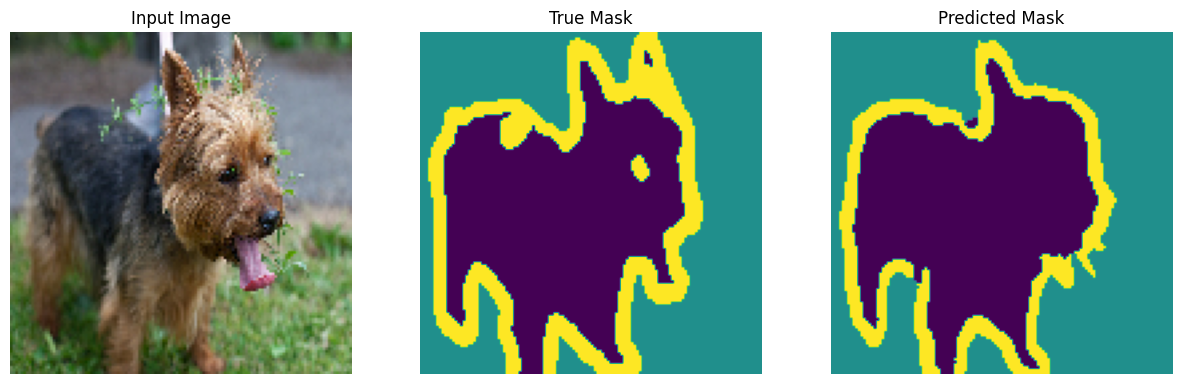

2/2 [==============================] - 0s 17ms/step


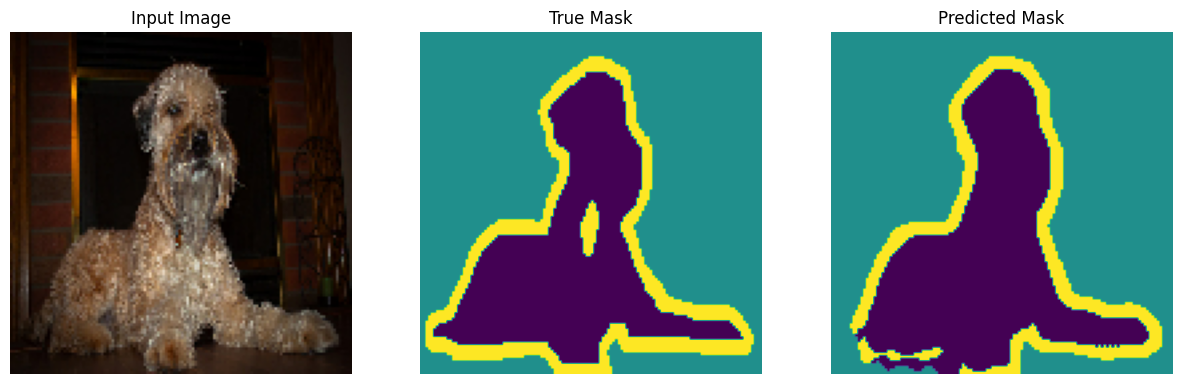

2/2 [==============================] - 0s 16ms/step


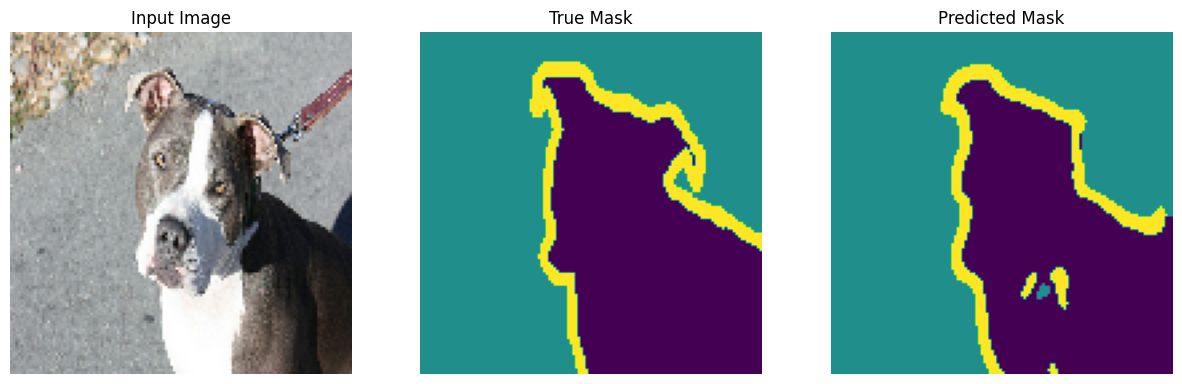

In [18]:
# Muestra las predicciones del modelo para tres imágenes del conjunto de prueba

show_predictions(test_batches.skip(5), 3)